### Explainability using Integrated Gradients for Natural Language Processing
(An amazing approach suggested in the paper https://arxiv.org/pdf/1703.01365.pdf,
allows us to attribute importance to each feature input,
regardless of model architecture)

---



In [87]:
pip install datasets

In [88]:
# Import all the libraries
import os
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import seaborn as sns
import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, rgb2hex
import pandas as pd
from IPython.display import HTML


pd.set_option('display.max_colwidth', 150)


In [89]:
# download the ag_news_subset dataset; https://www.tensorflow.org/datasets/catalog/ag_news_subset
# split them into train/val/test, train:val = 90:10
(raw_train_ds, raw_val_ds, raw_test_ds), info = tfds.load('IMDBReviews',
                                                          split=['train[:90%]',
                                                                 'train[-90%:]',
                                                                 'test'],
                                                          with_info=True)


In [90]:
# prompt: i want to use 3 class  dataset

# Filter the dataset to only include the first three classes
raw_train_ds = raw_train_ds.filter(lambda x: x['label'] < 3)
raw_val_ds = raw_val_ds.filter(lambda x: x['label'] < 3)
raw_test_ds = raw_test_ds.filter(lambda x: x['label'] < 3)


In [91]:
raw_test_ds

<_FilterDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [92]:
_LABEL_NAMES = info.features['label'].names
print(_LABEL_NAMES)

['neg', 'pos']


In [93]:
batch_size = 128

In [94]:
# convert a sample of dataset into pandas df for easy viewing
train_sample_df = \
    tfds.as_dataframe(raw_train_ds.shuffle(batch_size).take(5),
                      ds_info=info)[[ 'label','text']]
train_sample_df['topic'] = \
    train_sample_df['label'].apply(lambda x: _LABEL_NAMES[x])

In [95]:
(train_sample_df.head())

,label,text,topic
0,0,b'One of the weaker Carry On adventures sees Sid James as the head of a crime gang stealing contraceptive pills. The fourth of the series to be ho...,neg
1,0,"b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they alway...",neg
2,1,"b""I first saw this as a child living in East London. The scars of Hitlers Luftwaffe were all too evident and the landscape of the movie was remini...",pos
3,1,b'I was surprised at the low rating this film got from viewers. I saw it one late night on TV and it hit the spot - I actually think it was back i...,pos
4,0,"b""The director Sidney J. Furie has created in Hollow Point a post-modern absurdist masterpiece that challenges and constantly surprises the audien...",neg


The Model's goal is to predict the topic (label) given the description.

In [96]:
# Need to covert the dataset from dict to tuple;

@tf.autograph.experimental.do_not_convert
def convert_ds_to_tuple(sample):

    """ the original dataset is of the form of a dict
     {description: (), label: (), title: ()}

      TF's model.fit() method required datasets to be of the form
      A tf.data dataset that returns a tuple of (inputs, targets)"""

    return sample['text'], sample['label']


# converting all datasets from dicts to tuples
raw_train_ds = raw_train_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_val_ds = raw_val_ds.map(convert_ds_to_tuple).batch(batch_size)
raw_test_ds = raw_test_ds.map(convert_ds_to_tuple).batch(batch_size)


In [97]:
# initiating model building;
# build the tokenizer layer first
vocab_size = 1000
e_dim = 64
n_classes = info.features['label'].num_classes
pre_processing_layer = TextVectorization(max_tokens=vocab_size,
                                         output_sequence_length=50,
                                         name='Notes_preprocessing_layer')

# fit the training set to the layer
pre_processing_layer.adapt(raw_train_ds.map(lambda x, y: x))
# store the vocab
vocab = pre_processing_layer.get_vocabulary()

In [98]:
# vectorize the text inputs

@tf.autograph.experimental.do_not_convert
def vectorize_text(text, label):

    """ convert text to tokens """

    text = tf.expand_dims(text, -1)
    return pre_processing_layer(text), label


# print an example
text_batch, label_batch = next(iter(raw_train_ds.shuffle(50)))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", _LABEL_NAMES[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review:  tf.Tensor(b"The trailers for this film were better than the movie. What waste of talent and money. Wish I would've waited for this movie to come on DVD because at least I wouldn't be out $9. The movie totally misses the mark. What could have been a GREAT movie for all actors, turned out to be a B-movie at best. Movie moved VERY slow and just when I thought it was going somewhere, it almost did but then it didn't. In this day and age, we need unpredictable plot twists and closures in film, and this film offered neither. The whole thing about how everyone is a suspect is good, however, not sure if it was the way it was directed, the lighting, the delivery of lines, the writing or what, but nothing came from it. Lot of hype for nothing. I was VERY disappointed in this film, and I'm telling everyone NOT to see it. The cheesy saxophone music throughout made the film worse as well. And the ending had NOTHING to do with the rest of the film. What a disappointment.", shape=(), dtype=s

In [99]:
# tokenize all datasets and prepare for training
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [100]:
# Build the model
# lets build a simple Bi-directional LSTM model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=e_dim,
                              name='embedding',
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax', name='probs')
])


In [101]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 probs (Dense)               (None, 2)                 34        
                                                                 
Total params: 89906 (351.20 KB)
Trainable params: 89906 (351.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [103]:
# train the model; lets try for 5 epochs
model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

Epoch 1/5
176/176 [==============================] - 65s 345ms/step - loss: 0.6048 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.4983 - val_sparse_categorical_accuracy: 0.7569
Epoch 2/5
176/176 [==============================] - 43s 243ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.4728 - val_sparse_categorical_accuracy: 0.7695
Epoch 3/5
176/176 [==============================] - 42s 241ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.7810
Epoch 4/5
176/176 [==============================] - 43s 244ms/step - loss: 0.4613 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.4383 - val_sparse_categorical_accuracy: 0.7934
Epoch 5/5
176/176 [==============================] - 43s 243ms/step - loss: 0.4426 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.4211 - val_sparse_categorical_accuracy: 0.8054


In [104]:
# evaluate the model
model.evaluate(test_ds, verbose=2)


196/196 - 7s - loss: 0.5256 - sparse_categorical_accuracy: 0.7370 - 7s/epoch - 33ms/step


[0.525570809841156, 0.7369599938392639]

In [105]:
# get predictions
test_probs = model.predict(test_ds)
test_preds = tf.argmax(test_probs, axis=1)
test_labels = \
    test_ds.flat_map(lambda x, y:
                     tf.data.Dataset.from_tensor_slices(y)).as_numpy_iterator()
test_labels = tf.convert_to_tensor(list(test_labels), dtype=test_preds.dtype)

196/196 [==============================] - 7s 32ms/step


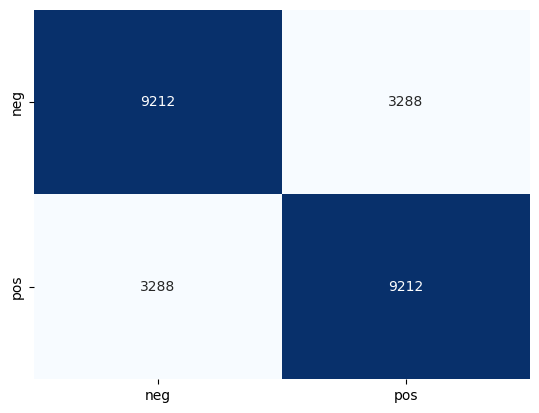

In [106]:
# build confusion matrix
cm = tf.math.confusion_matrix(test_labels, test_preds)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=_LABEL_NAMES,
            yticklabels=_LABEL_NAMES, cbar=False)
plt.show()

### INTEGRATED GRADIENTS for understanding feature importance
Refer to https://arxiv.org/pdf/1703.01365.pdf for all the details


##### VERY IMPORTANT : in Tensorflow, gradients dont pass through Embedding layer; so will get the embedding layer out, and build the rest of the model as `new_model`


In [107]:
embed_layer = model.get_layer('embedding')

# build new model with all layers after embedding layer
new_model = tf.keras.Sequential()
for layer in model.layers[1:]:
    new_model.add(layer)

In [108]:
# take some test data
sample_vectors = next(test_ds.take(1).as_numpy_iterator())[0]
sample_texts = next(raw_test_ds.take(1).as_numpy_iterator())[0]
sample_labels = next(test_ds.take(1).as_numpy_iterator())[1]

Run all the code below this line to visualize a different example

In [120]:
# select a random index
index = tf.cast(tf.random.uniform(shape=[1],
                                  minval=sample_vectors.shape[0]),
                dtype=tf.int8).numpy()[0]
# generate a random sample
sample_text = sample_texts[index]
sample_vector = sample_vectors[index]
sample_label = sample_labels[index]
# get embeddings
sample_embed = embed_layer(sample_vector)
# Create a Baseline vector with zero embeddings
baseline_embed = tf.zeros(shape=tf.shape(sample_embed))
# get preds for sample
sample_preds = model(sample_vectors)[index]
# print the results with color codes
words = [vocab[i] for i in sample_vector]

In [111]:
def interpolate_texts(baseline, text, m_steps):

    """ Linearly interpolate the input vector
    (embedding layer output of the sample vector)"""

    # Generate m_steps intervals for integral_approximation() below.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # text = tf.cast(text, tf.float32)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    delta = text - baseline
    texts = baseline + alphas_x * delta
    return texts

In [112]:
n_steps = 50

interpolated_texts = interpolate_texts(baseline_embed,
                                       sample_embed,
                                       n_steps)

In [113]:
interpolated_texts.shape
# (num_interpolations, seq_len, embed_dim)

TensorShape([51, 50, 64])

In [114]:
def compute_gradients(t, target_class_idx):

    """ compute the gradient wrt to embedding layer output """

    with tf.GradientTape() as tape:
        tape.watch(t)
        probs = new_model(t)[:, target_class_idx]
    grads = tape.gradient(probs, t)
    return grads

In [25]:
target_label = sample_label
# target_label = 2
path_gradients = compute_gradients(interpolated_texts, target_label)

In [26]:
path_gradients.shape
# (num_interpolations, seq_len, embed_dim)

TensorShape([51, 50, 64])

In [115]:
# sum the grads of the interpolated vectors
all_grads = tf.reduce_sum(path_gradients, axis=0) / n_steps
# mulitply grads by (input - baseline); baseline is zero vectors
x_grads = tf.math.multiply(all_grads, sample_embed)
# sum all gradients across the embedding dimension
igs = tf.reduce_sum(x_grads, axis=-1).numpy()

In [116]:
# took the code for this cell block from
#  https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_imdb.html

def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """

    cmap_bound = tf.reduce_max(tf.abs(attrs))
    norm = Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: rgb2hex(cmap(norm(x))), attrs))
    return colors

In [117]:
colors = colorize(igs)

<ipython-input-116-ac2b22f3d3a9>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


In [121]:
# print the sample and predictions
print(f"Sample Text: {sample_text}\n")
# print(f"Sample Vector: {sample_vector}")
# print(f"True Label: {_LABEL_NAMES[sample_label]}")
# print(f"Predicted Label: "
#       f"{_LABEL_NAMES[tf.argmax(sample_preds).numpy()]}")
print("Predictions : ")
for index in tf.argsort(sample_preds,
                        axis=-1, direction='DESCENDING').numpy():
    print(f"\t{_LABEL_NAMES[index]} --> {sample_preds[index]*100:0.2f}%")

print(f"\nTrue Label: {_LABEL_NAMES[sample_label]}")
print(f"\nAttributions for Label: {_LABEL_NAMES[target_label]}")
print(f"\nTop 5 Important words: "
      f"{[words[i] for i in tf.argsort(igs, -1, 'DESCENDING')[:5]]}\n")
HTML("".join(list(map(hlstr, words, colors))))

Sample Text: b"This is another one of those movies I just knew I would hate, but it ended up not being as bad as one would expect.<br /><br />It has a lot of T&A in it and even the DVD menu is chocked full of women's breast. The first few scenes of the movie has a lot of sex and nudity and I was beginning to think there would be no story at all just exploiting nudity for the sake of making money off a popular prequel 8MM.<br /><br />As I continued to watch there was just more sex and nudity and main characters that I could care less about, but then the story started to unfold and I started to see a point to it all, and it was a tad better.<br /><br />It is about a man who's fianc\xc3\xa9 is the daughter of an Ambasador and they all have a promising future until nude photos of a menage a trois sex act shows up and blackmail is in the senders cards. The man and his fianc\xc3\xa9 must now get to the bottom of who sent the pics and how to shut them up.<br /><br />The movie first of all is 

Importance of the words are highlighted. Greener the color, the higher positive attribution of that feature towards the prediction. Opposite for pink-colored words. As you can see, features such as 'olympic', 'champions`, 'league' are contributing the most towards predicting the sample as 'Sports'

